## Verinin Hazilanmasi ve Incelenmesi

In [97]:
# Kullanilabielcek Kutuphanelerin Yuklenmesi
# Veri setinin import edilmsi

import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings


warnings.filterwarnings("ignore")

df = pd.read_csv("Hourly Load Data.csv")
df

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0
...,...,...
32891,2001-01-01 20:00:00,35209.0
32892,2001-01-01 21:00:00,34791.0
32893,2001-01-01 22:00:00,33669.0
32894,2001-01-01 23:00:00,31809.0


In [4]:
# Burada goruldugu gibi Datetime object turunde bunun degistirilmesi ve tarih formatina getirilmesi gerekiyor.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


In [98]:
# Tarih formatina getirilmesi

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(["Datetime"],ascending=True,inplace=True)
df.reset_index(inplace=True,drop="İndex")

In [99]:
# Herhangi bir eksik gozlem yok 

df.isnull().sum()

Datetime       0
PJM_Load_MW    0
dtype: int64

In [100]:
# Simdi Tarih sutununu kullanarak Ay, haftanin gunu, ceyreklik, yil ve saat olarak bolelim

df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.dayofweek
df['year'] = df['Datetime'].dt.year
df['hour'] = df['Datetime'].dt.hour
df['quarter'] = df['Datetime'].dt.quarter

In [101]:
# Islemden sonra bir goz gecirelim veri setine
# Veri setine ekstra olarak ay, haftanin gunu, ceyreklik, saat ve yil olmak uzere 5 degisken daha eklemis oluyoruz.


df

,Datetime,PJM_Load_MW,month,day,year,hour,quarter
0,1998-04-01 01:00:00,22259.0,4,2,1998,1,2
1,1998-04-01 02:00:00,21244.0,4,2,1998,2,2
2,1998-04-01 03:00:00,20651.0,4,2,1998,3,2
3,1998-04-01 04:00:00,20421.0,4,2,1998,4,2
4,1998-04-01 05:00:00,20713.0,4,2,1998,5,2
...,...,...,...,...,...,...,...
32891,2001-12-31 20:00:00,36392.0,12,0,2001,20,4
32892,2001-12-31 21:00:00,35082.0,12,0,2001,21,4
32893,2001-12-31 22:00:00,33890.0,12,0,2001,22,4
32894,2001-12-31 23:00:00,32590.0,12,0,2001,23,4


### - Birkac Gorsellestirme Ile Devam Edelim

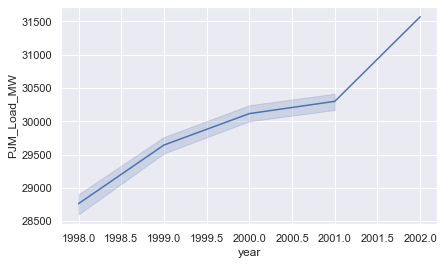

In [102]:
# Yillara gore bir gorsellestirme yaptigimiz zaman PJM_Load_MW degerinin artan bir trend ile devam ettigini gosteriyor

sns.lineplot(x="year", y="PJM_Load_MW",
             data=df)

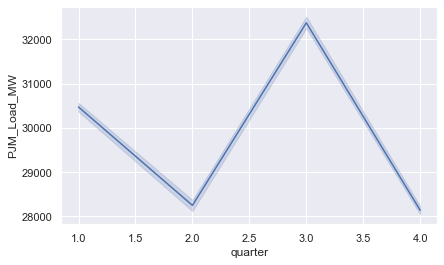

In [103]:
# Ceyreklikler baz alindiginda ise elektrik kullaniminda 1. ve 3. ceyrekte kullanim yuksek iken 2. ve 4. ceyrekte kullanim orani dusuyor 

sns.lineplot(x="quarter", y="PJM_Load_MW",
             data=df)

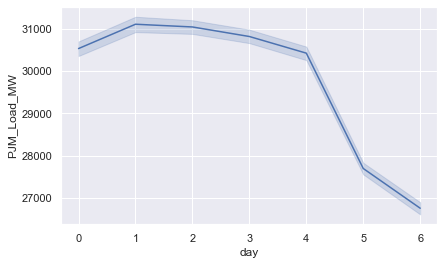

In [104]:
# Gunluk olarak degerlendirildiginde ise elektrik kullanimi hafta ici daha fazla iken hafta sonu bir dusus oldugunu gorebiliyoruz genel olarak

sns.lineplot(x="day", y="PJM_Load_MW",
             data=df)

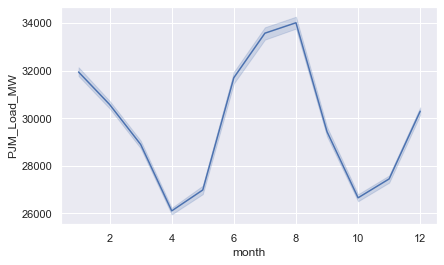

In [105]:
# Son olarak aylar baz alindiginda ise 1. ve 2. ay bazinda bir yukseklik var ama ardindan bir dusus ile devam ediyor
# Daha sonra 4. aydan itibaren yukselen bir trende giriyor. 
# Yaz aylarinda elektrik tuketiminin fazlaca oldugunu gorebiliyoruz

sns.lineplot(x="month", y="PJM_Load_MW",
             data=df)

In [106]:
# Bir olceklendirme yapabiliriz. 
# PJM_Load_MW degiskenimiz numericti bunu gruplayip hangi araliklarin kullanim sikliginin daha fazla oldugu gorebiliriz.


def MWh_dist(data):
   
    MWh_df = data.copy(deep=True)
    MWh_df['MWh_bins'] = pd.cut(MWh_df.PJM_Load_MW, [20000, 25000, 30000, 40000 ])
    print('Max MWh:', MWh_df.PJM_Load_MW.max())
    print('Min MWh:', MWh_df.PJM_Load_MW.min())
    print('Avg MWh:', MWh_df.PJM_Load_MW.mean())
    print()
    return MWh_df

MWh_df = MWh_dist(train_df)

# Total number of data points
total_points = pd.value_counts(MWh_df.MWh_bins).sum()
print('MWh bucket v/s Total percentage:')
display(pd.value_counts(MWh_df.MWh_bins).apply(lambda s: (s/total_points)*100))

Max MWh: 51714.0
Min MWh: 17461.0
Avg MWh: 29571.414216397792

MWh bucket v/s Total percentage:


(30000, 40000]    42.898394
(25000, 30000]    34.244721
(20000, 25000]    22.856885
Name: MWh_bins, dtype: float64

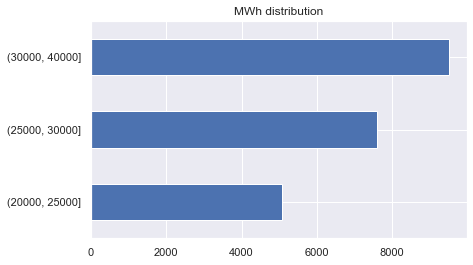

In [107]:
# Goruldugu uzere buyukten kucuge doru giden bir kullanim durumu var.

MHW_count = pd.value_counts(MWh_df.MWh_bins)
MHW_count.sort_values(ascending=True).plot(kind='barh', title='MWh distribution', );

### - Veri Setinin Ikiye Ayrilmasi ve Model 

In [87]:
# Burada SHUFFLE = FALSE cunku zaman serileri ile calisirken seri tarihsel olarak siralanir ve serinin tahmin edilecek kismi modele gosterilmez
# Ilk once modelimizi sinarken VALIDASYON seti ile yapacagiz.

train_df= df.loc[:26315,:].copy()
test_df = df.loc[26316:,:].copy()

def split_data(train_data,test_data):

    col = [i for i in test_data.columns if i not in ['Datetime','PJM_Load_MW']]
    y = 'PJM_Load_MW'
    train_x, test_val, train_y, test_y_val = train_test_split(train_data[col],train_data[y], test_size=0.23,  random_state=42,shuffle=False)
    return (train_x, test_val, train_y, test_y_val,col)

train_x, test_val, train_y, test_y_val,col = split_data(train_df,test_df)

train_x.shape,train_y.shape,test_val.shape,test_y_val.shape

((20263, 5), (20263,), (6053, 5), (6053,))

In [88]:
# Model olarka LIGHTGBM ile devam ediyoruz.
# Yakin zamanda cikan lihtgbm microsoft tarafindan piyasa surulmustur ve cok iyi sonuclar vermektedir.
# Arastirmalar sonucu belli basli parametreleri kullandim ve validasyon setinin tahmin suresinde metric olarak MAPE ele aldim.


def model(train_x,train_y,test_val,test_y_val,col):
    params = {
        'nthread': 10,
         'max_depth': 5,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape',
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_val,test_y_val)
    model = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    y_pred = model.predict(test_df[col])
    return y_pred,model

In [89]:
%%time
y_pred, model = model(train_x,train_y,test_x,test_y,col)

Training until validation scores don't improve for 50 rounds
[50]	training's mape: 0.0605783	valid_1's mape: 0.0624787
Early stopping, best iteration is:
[39]	training's mape: 0.0619624	valid_1's mape: 0.0606785
Wall time: 350 ms


### - MAPE indikatorunun degerlendirilmesi

In [90]:
# MAPE bilindigi uzere ortalama mutlak yuzde hata olarak gecmektedir
# Mape istatistigi farkli birim degerlere sahip modellerin karsilastirilmasinda kullanilmaktadir ve bu problemi elimine edebilmektedir 
# Bir makale de soyle yazmaktadir:

## MAPE <%10’un altında olan modeller “çok iyi”,
## % 10 < MAPE < % 20 arasında olan modelleri “iyi”,
## % 20 < MAPE < % 50 arasında olan modelleri “kabul edilebilir” ve %50< MAPE ’nin üzerinde olan modeller ise “yanlış ve hatalı” olarak sınıflandırılmıştır.

# MAPE sonucuna bakilmasi
# Train setinin MAPE degeri 0.0619624
# Validasyon setinin MAPE degeri 0.0606785 olarak bulundu
# Test setinin MAPE degeri ise 0.0663135991952795 buldugunu goruyoruz 
# Kurdugumuz modelin iyi bir derece tahmin gucu gerceklestirdigini gorduk

from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_df["PJM_Load_MW"],y_pred)

0.0663135991952795

### - Genel Degerlendirme

* -Porje kapsaminda sonuclarin hangi hangi cografyadan alindiginin bilinmesinde fayda olacaktir

* -Hangi sehirlerin oldugunu bilmek bize daha ayrintiya inip bolgelere gore daha belirli sonuclar elde etmemizi saglayacaktir

* -Bolgeseler kriterler uzerinde yapilacak olan calismalar daha cok ayrintiyi elde etmemizi saglayabilir. Ornegin bolgenin hava durumu, nufusu gibi degiskenler tahminleme sonucuna etkili olabilir.